In [151]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [183]:
# Get the vocabulary for the mappings of to and from intergers

words = open("names.txt",'r').read().splitlines()
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {v:k for k,v in stoi.items()}


In [121]:
# Build the dataset
X,Y = [],[]
context_length = 3

for w in words:
    context = [0] * context_length
    #print(w)
    for ch in w + '.':
        ix = stoi[ch]
        X.append(context)
        Y.append(ix)
        #print(f"{''.join(itos[i] for i in context)} ---> {itos[ix]}")
        context = context[1:] + [ix]

X = torch.tensor(X)
Y = torch.tensor(Y)

In [122]:
X.shape, X.dtype, Y.shape, Y.dtype


(torch.Size([228146, 3]), torch.int64, torch.Size([228146]), torch.int64)

In [64]:
C = torch.randn((27,2))
C

tensor([[ 1.4140, -0.9164],
        [ 0.6345, -0.9186],
        [-0.4419,  0.8661],
        [-0.1640, -0.3767],
        [ 0.1695,  0.7452],
        [-2.2785, -0.4671],
        [ 0.1070,  0.6598],
        [-0.5363,  1.1308],
        [ 1.4783,  0.9955],
        [-0.0713,  0.4893],
        [ 0.6374,  0.9106],
        [ 1.3740, -2.3133],
        [ 1.2617, -1.1571],
        [ 1.6125,  0.0337],
        [ 0.1694, -1.0704],
        [ 1.4233,  0.2604],
        [-1.0649, -0.5052],
        [ 0.3267,  0.1601],
        [ 1.0696, -0.2487],
        [ 0.4330, -1.8828],
        [ 0.0865,  0.5502],
        [ 0.4356,  0.5052],
        [ 0.5720,  0.0388],
        [-0.8659, -0.2791],
        [-2.6366,  0.6593],
        [-1.1495, -0.4954],
        [ 0.0128, -0.3272]])

In [67]:
# Create the embeddings
emb = C[X]
emb.shape

torch.Size([32, 3, 2])

In [82]:
# Create the hidden layer
W1 = torch.randn(6,100)
b1 = torch.randn(100)
h = torch.tanh(emb.view(emb.shape[0],6) @ W1 + b1)

torch.Size([32, 100])

In [84]:
# Create the output layer
W2 = torch.randn(100,27)
b2 = torch.randn(27)

logits = h @ W2 + b2


In [91]:
counts = logits.exp()
probs = counts / counts.sum(1,keepdim=True)
loss = -probs[torch.arange(32),Y].log().mean()
loss

tensor(12.2805)

In [198]:
#----- more respectable
Xtr.shape, Ytr.shape


(torch.Size([182484, 3]), torch.Size([182484]))

In [241]:
# This resets the network
g = torch.Generator().manual_seed(2147483647)
#C = torch.randn((27,2), generator=g)
C = torch.randn((27,10), generator=g) # increase embedding from 2 to 10 dimensions
#W1 = torch.rand((6,100), generator=g)
W1 = torch.rand((30,200), generator=g) # The weights are N embedding dimensions * content_length
b1 = torch.randn(200, generator=g)
W2 = torch.randn(200,27, generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C , W1, b1, W2, b2]

In [242]:
# this is the total amount of hyperparameters
sum(p.nelement() for p in parameters)

11897

In [254]:
import random
random.seed(42)
context_length=3 # aka block size
def build_dataset(words):
    # Build the dataset
    X,Y = [],[]

    for w in words:
        context = [0] * context_length
        #print(w)
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            #print(f"{''.join(itos[i] for i in context)} ---> {itos[ix]}")
            context = context[1:] + [ix]

    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y

random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

total_set = build_dataset(words)
Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])


torch.Size([228146, 3]) torch.Size([228146])
torch.Size([182661, 3]) torch.Size([182661])
torch.Size([22763, 3]) torch.Size([22763])
torch.Size([22722, 3]) torch.Size([22722])


In [244]:
for p in parameters:
    p.requires_grad = True


In [245]:
# Let's expore the best learning rate
lre = torch.linspace(-3, 0, 1000)
lrs = 10**lre

In [246]:
lri = []
lossi = []
stepi = []


In [250]:
# Train the dataset
batch_size = 32
for i in range(50000):
    # forward pass
    batch_size = 32
    ix = torch.randint(0, Xtr.shape[0], (batch_size, )) # take 32 random rows
    emb = C[Xtr[ix]]
    h = torch.tanh(emb.view(-1,30) @ W1 + b1)
    logits = h @ W2 + b2 
    counts = logits.exp()
    loss = F.cross_entropy(logits, Ytr[ix])
    #print(f"loss: {loss.item()}")
    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()
    # update
    # lr = lrs[i]
    lr = 0.01
    for p in parameters:
        p.data += -lr * p.grad

    # track states 
    # lri.append(lre[i])
    # lossi.append(loss.item())
    stepi.append(i)
    lossi.append(loss.log10().item())
print(f"Batch Loss: {loss}")

Batch Loss: 2.3483269214630127


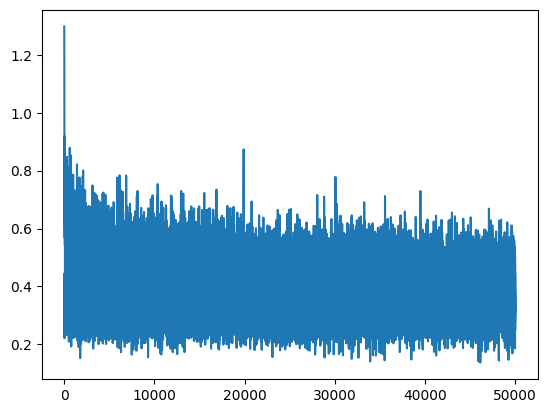

In [251]:
plt.plot(stepi, lossi)

In [252]:
# Dev Loss
emb = C[Xdev]
h = torch.tanh(emb.view(-1,30) @ W1 + b1)
logits = h @ W2 + b2 
counts = logits.exp()
loss = F.cross_entropy(logits, Ydev)
print(loss)

# Test Loss
# emb = C[Xte]
# h = torch.tanh(emb.view(-1,30) @ W1 + b1)
# logits = h @ W2 + b2 
# counts = logits.exp()
# loss = F.cross_entropy(logits, Yte)
# print(loss)


tensor(2.1826, grad_fn=<NllLossBackward0>)
tensor(2.1882, grad_fn=<NllLossBackward0>)


1. We need to determine the proper learning rate using the above code.
   From the above plot, it looks like the exponent of the learning rate should be -1.0, or 0.1
2. Train for 10-20k steps
3. Once we've trained, do a learning rate decay, say by a factor of 10. So 0.1 -> 0.01

In [196]:
22774 / 228146

0.09982204377898363

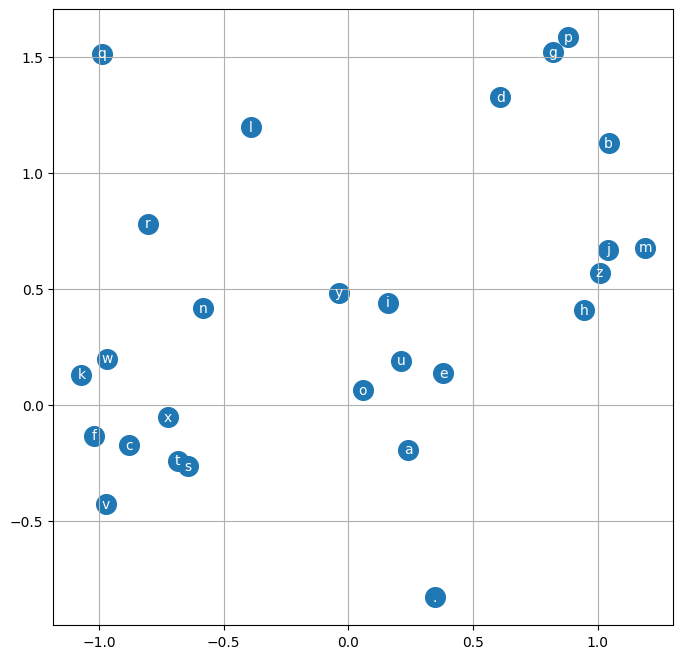

In [215]:
# Let's examine embeddings
plt.figure(figsize=(8,8))
plt.scatter(C[:,0].data, C[:,1].data, s=200)
for i in range(C.shape[0]):
    plt.text(C[i,0].item(), C[i,1].item(), itos[i], ha="center", va="center", color="white")
plt.grid('minor')



In [263]:
# Let's generate some names!
# run inference on samples
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):

    out = []
    context = [0] * context_length
    while True:
        emb = C[torch.tensor([context])] # (1, block_size, d)
        h = torch.tanh(emb.view(1, -1) @ W1 + b1)
        logits = h @ W2 + b2
        probs = F.softmax(logits, dim=1)
        ix = torch.multinomial(probs, num_samples=1).item()
        context = context[1:] + [ix]
        out.append(ix)
        if ix == 0:
            break
    print(''.join(itos[i] for i in out))

    

firlie.
ohnna.
rick.
axhid.
kosiah.
sthayah.
eah.
kyling.
iana.
emrickishar.
hiton.
karres.
lalen.
emerice.
peon.
dakharpton.
nard.
yylani.
amoni.
kaylyn.


3